# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression




In [20]:
future = pd.read_excel("data/futures.xlsx", header=0)

In [21]:
future["date"]= pd.to_datetime(future["date"])
future.ffill(inplace=True)
future = future[future['date'] >= "2024-01-01"]

future.head()

,date,TRFRBYc1,TRFRBMc1,TRFRBFVMG6,TRFRBFVMH6,TRFRBFVMJ6,TRFRBFVMK6,TRFRBFVMM6,TRFRBFVMN6,TRFRBFVMQ6,...,TRFRBFVMH7,TRFRBFVMJ7,TRFRBFVMK7,TRFRBFVMM7,TRFRBFVMN7,TRFRBFVMQ7,TRFRBFVMU7,TRFRBFVMV7,TRFRBFVMX7,TRFRBFVMZ7
0,2026-01-09,49.45000,76.85000,76.69000,57.38000,40.31000,20.86000,27.87000,37.38000,39.73000,...,65.94000,33.69000,16.92000,23.38000,31.89000,33.94000,36.19000,58.51000,68.85000,68.04000
1,2026-01-08,48.50000,74.65000,74.65000,56.40000,39.33000,19.65000,27.18000,36.04000,38.70000,...,65.12000,33.69000,16.81000,22.19000,31.37000,33.26000,35.46000,58.20000,68.49000,67.68000
2,2026-01-07,48.75000,73.50000,73.49000,56.79000,39.48000,19.60000,25.88000,35.54000,37.95000,...,65.63000,34.57000,16.24000,22.51000,31.18000,33.04000,35.23000,57.94000,68.18000,67.38000
3,2026-01-06,48.70000,72.70000,72.51000,56.16000,39.12000,18.27000,25.35000,34.55000,36.85000,...,65.10000,34.90000,16.09000,22.49000,31.33000,33.14000,35.34000,58.11000,68.38000,67.59000
4,2026-01-05,48.80000,70.00000,70.21000,54.91000,38.85000,17.80000,24.90000,34.05000,36.25000,...,64.98000,35.02000,16.86000,22.90000,31.13000,32.86000,35.02000,58.22000,68.52000,67.69000


In [22]:
# Lecture et traitement des fichiers Spot22, Spot23, Spot24, Spot25
spot_files = ["data/spot_price_22.xlsx", "data/spot_price_23.xlsx", "data/spot_price_24.xlsx", "data/spot_price_25.xlsx"]
spot_data = []

for file in spot_files:
    spot = pd.read_excel(file)
    spot['Date'] = spot['Date'].str.split(' - ').str[0]  # Prendre uniquement le début de la plage
    spot['Date'] = pd.to_datetime(spot['Date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    spot = spot.dropna(subset=['Date'])  # Suppression des lignes avec des dates invalides
    daily = spot.groupby(spot['Date'].dt.date)['Day-ahead'].mean().reset_index()
    daily.rename(columns={'Date': 'date', 'Day-ahead': 'price'}, inplace=True)
    spot_data.append(daily)

# Fusion des bases de données
spot_merged = pd.concat(spot_data).groupby('date', as_index=False)['price'].mean()

# Affichage des premières lignes du résultat
spot_merged.head()


,date,price
0,2022-01-01,86.26083
1,2022-01-02,47.40750
2,2022-01-03,97.81000
3,2022-01-04,157.44667
4,2022-01-05,189.49417


In [23]:
spot_merged.loc[spot_merged['price'] <= 0, 'price'] = np.nan
spot_merged['price'] = spot_merged['price'].ffill()

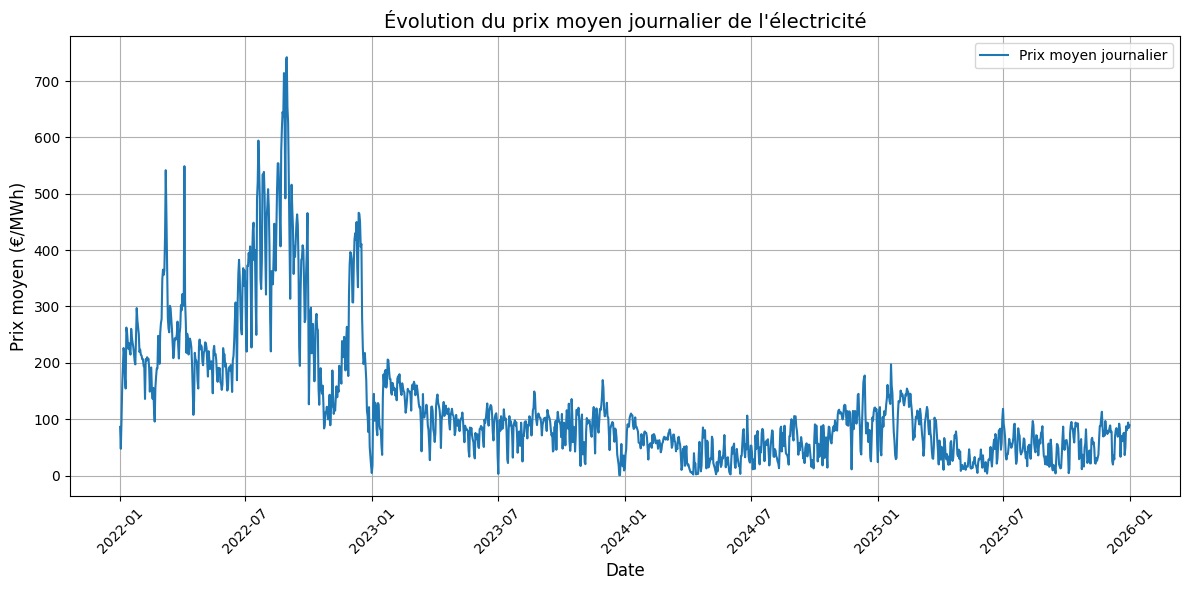

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Convertir la colonne 'date' en type datetime64 pour éviter les incompatibilités de types
spot_merged['date'] = pd.to_datetime(spot_merged['date'])

# Filtrer les données pour conserver uniquement les dates à partir du 1er janvier 2023
spot_merged = spot_merged[spot_merged['date'] >= pd.Timestamp('2023-01-01')]


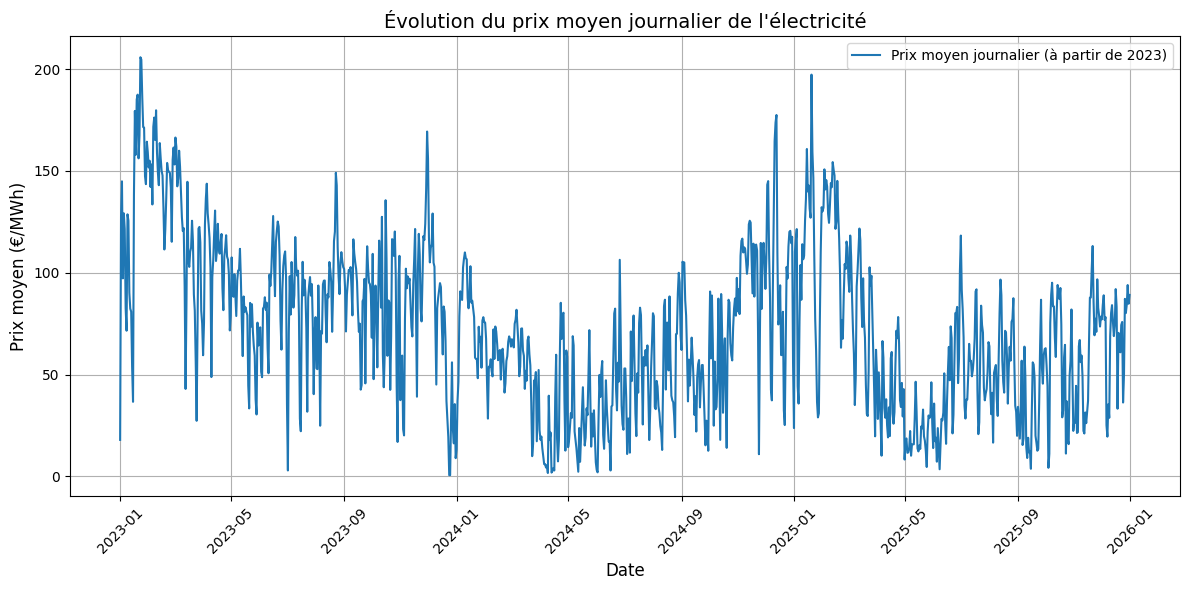

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier (à partir de 2023)')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Ajouter des colonnes "jour", "mois", "semaine" et "saison"
spot_merged['jour'] = spot_merged['date'].dt.day_name()
spot_merged['mois'] = spot_merged['date'].dt.month_name()
spot_merged['semaine'] = spot_merged['date'].dt.isocalendar().week
spot_merged['saison'] = spot_merged['date'].dt.month % 12 // 3 + 1
spot_merged['saison'] = spot_merged['saison'].map({1: 'Hiver', 2: 'Printemps', 3: 'Été', 4: 'Automne'})


Statistiques descriptives par jour de la semaine:
              count     mean      std      min      25%      50%       75%  \
jour                                                                         
Friday    156.00000 77.54795 37.99210  6.00833 54.38823 78.79307  99.00906   
Monday    157.00000 76.07220 40.31124  0.60000 46.89292 73.59042 101.27667   
Saturday  156.00000 61.73325 36.33154  1.85875 31.77990 56.75187  86.25021   
Sunday    157.00000 51.74475 37.18165  0.59750 19.77875 45.53667  74.29125   
Thursday  156.00000 79.25484 39.66388  7.23167 52.84083 80.16828 105.51510   
Tuesday   157.00000 79.42343 40.00481  1.65917 49.84792 77.17833 105.36625   
Wednesday 157.00000 80.16303 38.41783 13.78542 51.24542 82.27583 101.95500   

                max  
jour                 
Friday    187.44583  
Monday    205.83000  
Saturday  156.18250  
Sunday    167.33417  
Thursday  185.08083  
Tuesday   204.69333  
Wednesday 186.34750  

Statistiques descriptives par mois:
            

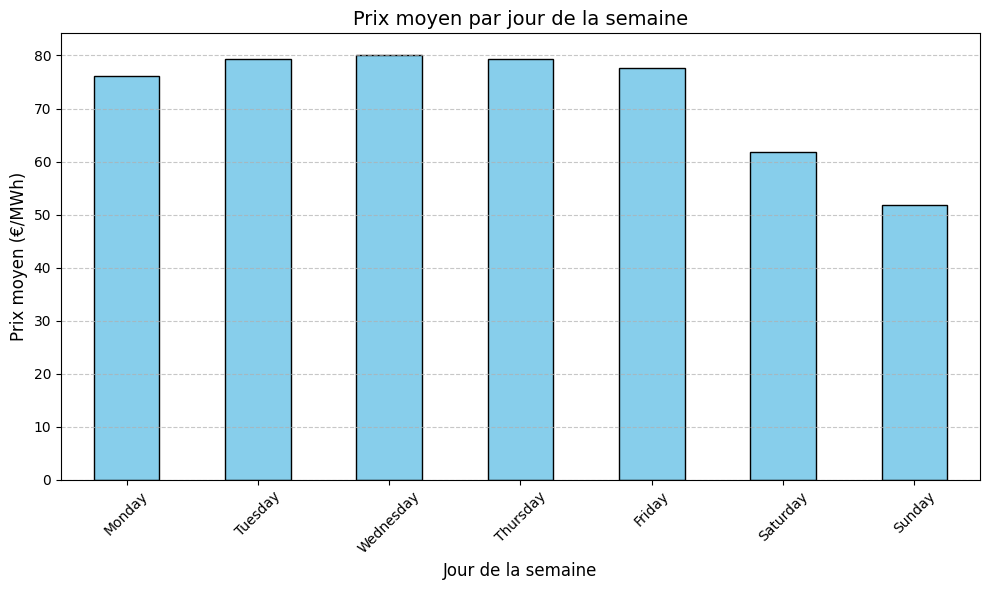

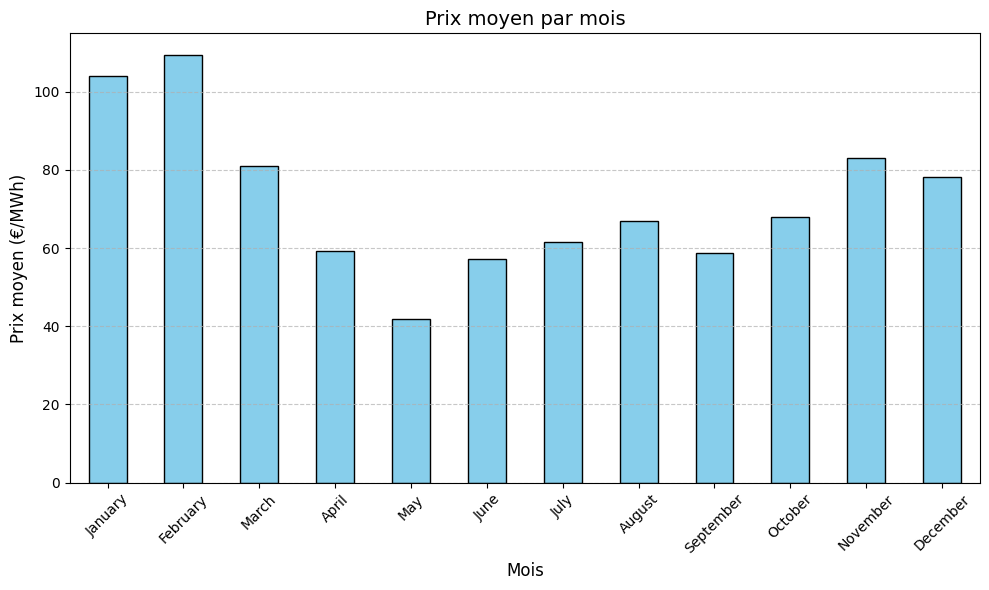

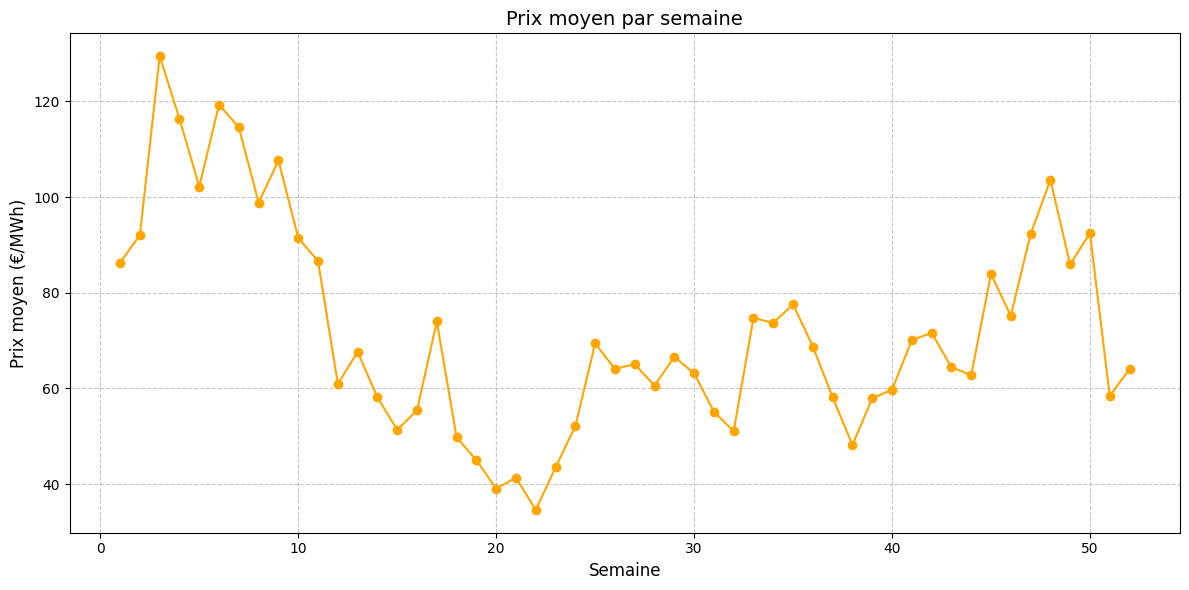

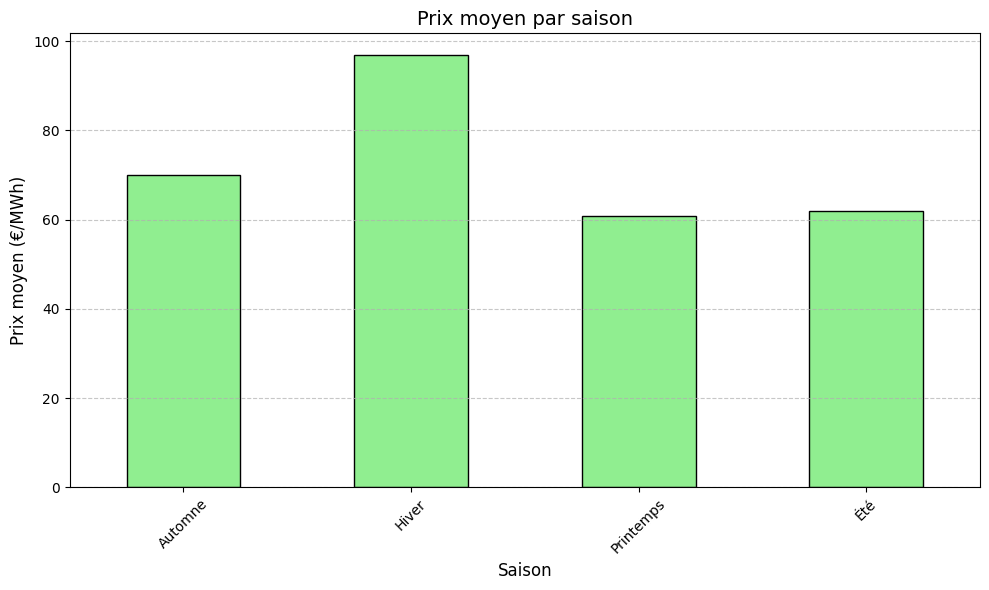

<Figure size 1200x800 with 0 Axes>

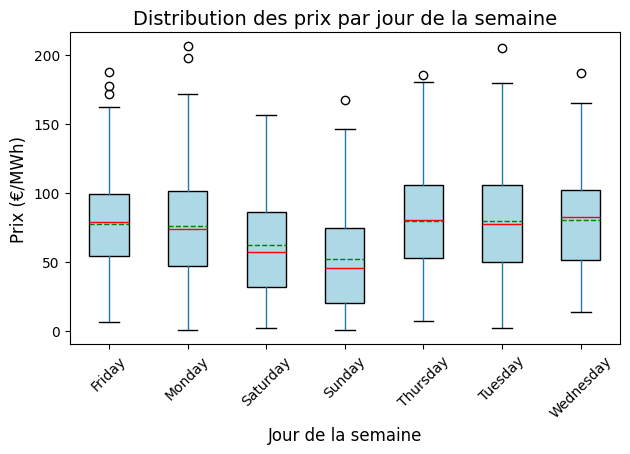

<Figure size 1200x800 with 0 Axes>

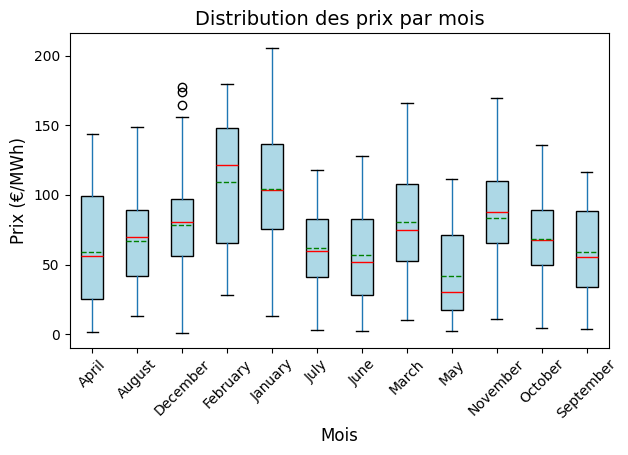

<Figure size 1200x800 with 0 Axes>

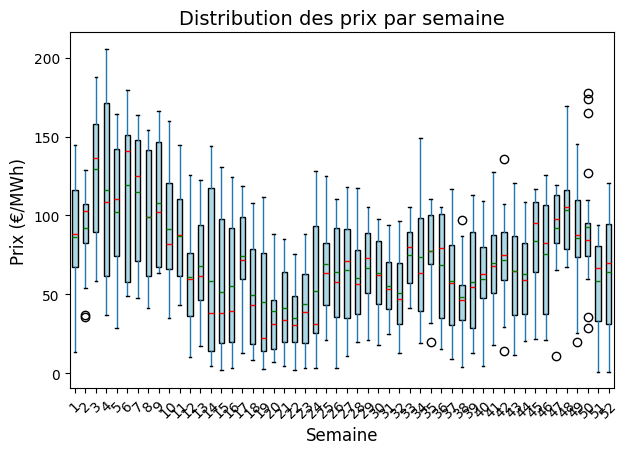

<Figure size 1200x800 with 0 Axes>

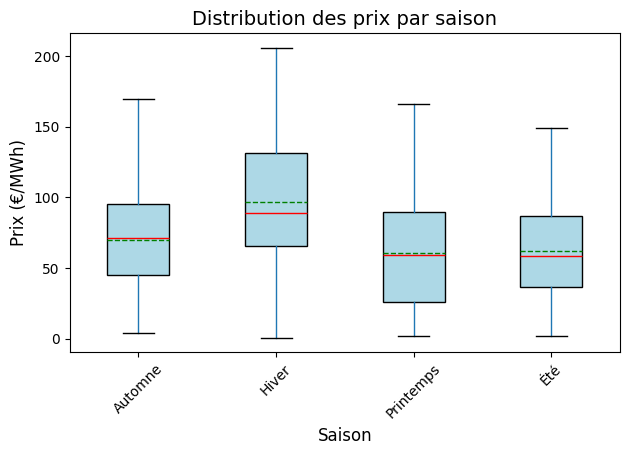

In [28]:
# Statistiques descriptives pour mesurer la saisonnalité par jour, mois, semaine et saison
stats_by_day = spot_merged.groupby('jour')['price'].describe()
stats_by_month = spot_merged.groupby('mois')['price'].describe()
stats_by_week = spot_merged.groupby('semaine')['price'].describe()
stats_by_season = spot_merged.groupby('saison')['price'].describe()

print("Statistiques descriptives par jour de la semaine:")
print(stats_by_day)
print("\nStatistiques descriptives par mois:")
print(stats_by_month)
print("\nStatistiques descriptives par semaine:")
print(stats_by_week)
print("\nStatistiques descriptives par saison:")
print(stats_by_season)

# Graphique de la moyenne des prix par jour de la semaine
plt.figure(figsize=(10, 6))
spot_merged.groupby('jour')['price'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par jour de la semaine", fontsize=14)
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par mois
plt.figure(figsize=(10, 6))
spot_merged.groupby('mois')['price'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par mois", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par semaine
plt.figure(figsize=(12, 6))
spot_merged.groupby('semaine')['price'].mean().plot(color='orange', linestyle='-', marker='o')
plt.title("Prix moyen par semaine", fontsize=14)
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par saison
plt.figure(figsize=(10, 6))
spot_merged.groupby('saison')['price'].mean().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Prix moyen par saison", fontsize=14)
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par jour de la semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='jour', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par jour de la semaine", fontsize=14)
plt.suptitle("")  # Supprimer le titre par défaut de boxplot
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par mois
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='mois', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par mois", fontsize=14)
plt.suptitle("")
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='semaine', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par semaine", fontsize=14)
plt.suptitle("")
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par saison
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='saison', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par saison", fontsize=14)
plt.suptitle("")
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# 1. Prépare les données (Log-Prix & Mois continu pour lissage)
spot_merged['log_price'] = np.log(spot_merged['price'])
# Crée un axe temporel lisse (ex: 15 Jan = 1.48) pour éviter les escaliers
spot_merged['t_smooth'] = spot_merged['date'].dt.month + (spot_merged['date'].dt.day - 1) / spot_merged['date'].dt.days_in_month

# 2. Agrégation Mensuelle (Calibration sur 12 points seulement)
monthly = spot_merged.groupby(spot_merged['date'].dt.month)['log_price'].mean()
X_fit, Y_fit = monthly.index.values, monthly.values

# 3. Fonction Fourier dynamique
def fourier(x, *a):
    res = a[0]
    for i in range((len(a)-1)//2):
        k = 2 * np.pi * (i+1) * x / 12
        res += a[2*i+1] * np.sin(k) + a[2*i+2] * np.cos(k)
    return res

# 4. Calibration (Trouve le meilleur ordre entre 1 et 3)
best = (float('inf'), None)
for order in range(1, 6):
    try:
        # p0 : Moyenne + des petits coeffs
        popt, _ = curve_fit(fourier, X_fit, Y_fit, p0=[np.mean(Y_fit)] + [0.1]*(2*order))
        resid = np.sum((Y_fit - fourier(X_fit, *popt))**2)
        if resid < best[0]: best = (resid, popt)
    except: pass

# 5. Application & Calcul de Xt
# On applique les params mensuels sur l'axe temporel lisse journalier
spot_merged['seasonality'] = fourier(spot_merged['t_smooth'], *best[1])
spot_merged['Xt'] = spot_merged['log_price'] - spot_merged['seasonality']

print(f"Saisonnalité calibrée (Ordre {(len(best[1])-1)//2})")

Saisonnalité calibrée (Ordre 5)


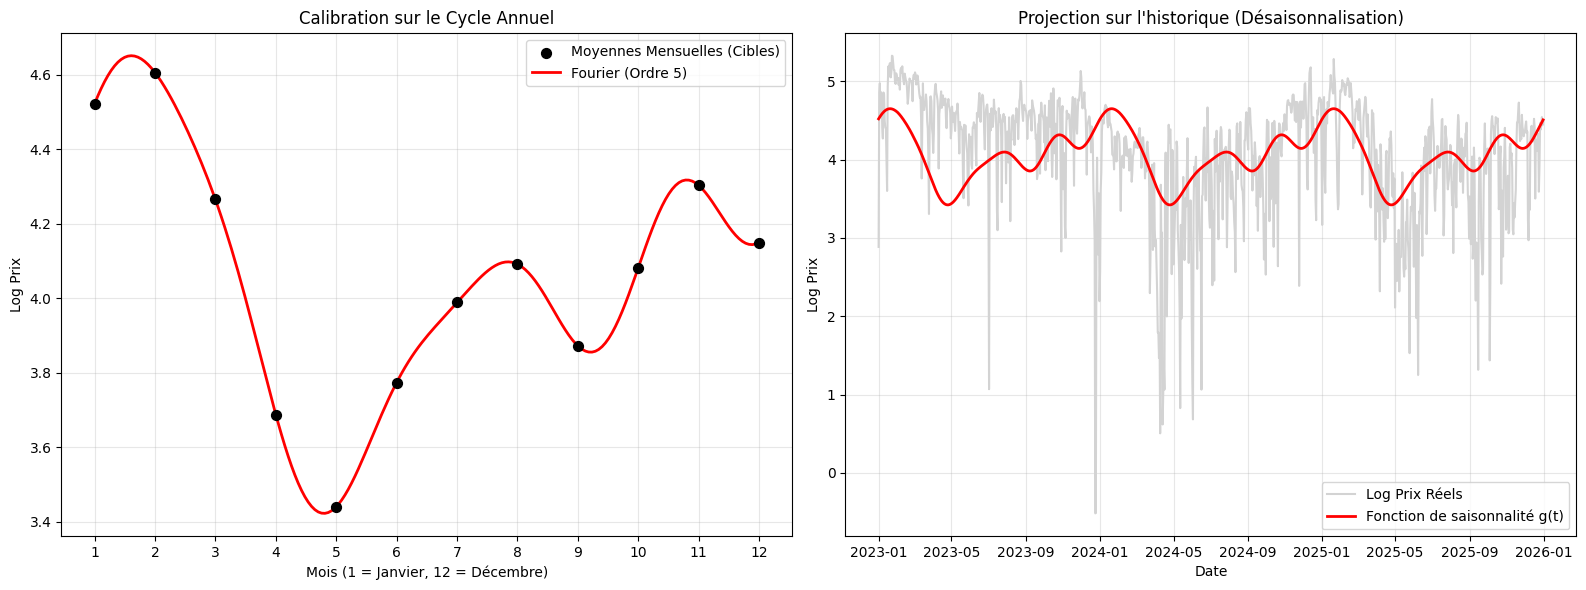

In [30]:
plt.figure(figsize=(16, 6))

# Graphique 1 : Calibration sur le cycle annuel
plt.subplot(1, 2, 1)
# Les points mensuels (Moyennes)
plt.scatter(X_fit, Y_fit, color='black', s=50, label='Moyennes Mensuelles (Cibles)', zorder=3)

# La courbe lissée (Fourier)
x_smooth_plot = np.linspace(1, 12, 200)
y_smooth_plot = fourier(x_smooth_plot, *best[1])
plt.plot(x_smooth_plot, y_smooth_plot, color='red', linewidth=2, label=f'Fourier (Ordre {(len(best[1])-1)//2})')

plt.title("Calibration sur le Cycle Annuel")
plt.xlabel("Mois (1 = Janvier, 12 = Décembre)")
plt.ylabel("Log Prix")
plt.xticks(np.arange(1, 13)) # Force l'affichage de 1 à 12
plt.grid(True, alpha=0.3)
plt.legend()

# Graphique 2 : Projection sur l'historique
plt.subplot(1, 2, 2)
# Les log-prix réels
plt.plot(spot_merged['date'], spot_merged['log_price'], color='lightgray', label='Log Prix Réels')

# Fonction de saisonnalité lissée
plt.plot(spot_merged['date'], spot_merged['seasonality'], color='red', linewidth=2, label='Fonction de saisonnalité g(t)')

plt.title("Projection sur l'historique (Désaisonnalisation)")
plt.xlabel("Date")
plt.ylabel("Log Prix")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
import numpy as np
from sklearn.linear_model import LinearRegression

Xt = spot_merged['Xt']
Y = Xt.diff().dropna()
X_lag = Xt.shift(1).dropna()

common_index = Y.index.intersection(X_lag.index)
Y = Y.loc[common_index].values.reshape(-1, 1)
X = X_lag.loc[common_index].values.reshape(-1, 1)

# Régression Linéaire
reg = LinearRegression(fit_intercept=False)
reg.fit(X, Y)

# La pente est égale à : - alpha * dt
slope = reg.coef_[0][0]
dt = 1 / 365.25 # Pas de temps journalier en années

alpha = -slope

print(f"Pente de la régression : {slope:.6f}")
print(f"Mean Reversion Rate journalier (Alpha*dt) : {alpha:.4f}")
print(f"Mean Reversion Rate annuel (Alpha) : {alpha/dt:.4f}")
print(f"Demi-vie : {-np.log(0.5)/alpha:.1f} jours environ")
print(f"99% du choc : {-np.log(0.01)/alpha:.1f} jours environ")

Pente de la régression : -0.291965
Mean Reversion Rate journalier (Alpha*dt) : 0.2920
Mean Reversion Rate annuel (Alpha) : 106.6403
Demi-vie : 2.4 jours environ
99% du choc : 15.8 jours environ


Itérations 8
Fréquence des sauts (J) : 18.00 sauts/an
Taille moyenne saut (Mu_J)   : 0.4210
Volatilité saut (Sigma_J)    : 1.8004


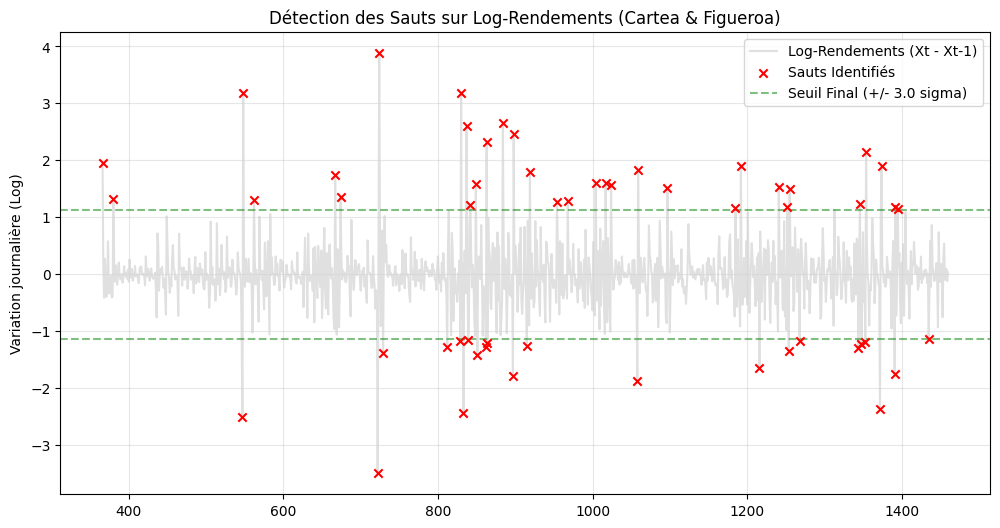

In [32]:
returns = spot_merged['Xt'].diff().dropna()
current_series = returns.copy()
jumps_found = []
jump_indices = []

# Seuil de détection des sauts (regle des 3-sigmas)
SIGMA_THRESHOLD = 3.0

iteration = 0
while True: 
    iteration += 1
    std_dev = current_series.std()
    is_jump = np.abs(current_series) > SIGMA_THRESHOLD * std_dev
    if not is_jump.any():
        break

    new_jumps = current_series[is_jump]
    jumps_found.extend(new_jumps.values)
    jump_indices.extend(new_jumps.index)

    current_series = current_series[~is_jump]
print(f"Itérations {iteration}")

# Paramètres des Sauts (Jumps)
jumps_array = np.array(jumps_found)

# J : Nombre de sauts par an
years = (spot_merged['date'].max() - spot_merged['date'].min()).days / 365
lambda_jump = len(jumps_array) / years

# Mu et Sigma du saut
mu_jump = jumps_array.mean()
sigma_jump = jumps_array.std()

print(f"Fréquence des sauts (J) : {lambda_jump:.2f} sauts/an")
print(f"Taille moyenne saut (Mu_J)   : {mu_jump:.4f}")
print(f"Volatilité saut (Sigma_J)    : {sigma_jump:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, color='lightgray', label='Log-Rendements (Xt - Xt-1)', alpha=0.7)
# Sauts détectés
plt.scatter(jump_indices, jumps_found, color='red', marker='x', label='Sauts Identifiés', zorder=5)
# Seuil final
limit = SIGMA_THRESHOLD * current_series.std()
plt.axhline(limit, color='green', linestyle='--', alpha=0.5, label=f'Seuil Final (+/- {SIGMA_THRESHOLD} sigma)')
plt.axhline(-limit, color='green', linestyle='--', alpha=0.5)

plt.title("Détection des Sauts sur Log-Rendements (Cartea & Figueroa)")
plt.ylabel("Variation journalière (Log)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Construction de la courbe forward**

In [33]:
# --- ÉTAPE A : COURBE FORWARD 2026 ---
# Mapping des mois Baseload France 2026 (G=Fev, H=Mar...)
mapping_2026 = {
    'TRFRBFVMG6': 2, 'TRFRBFVMH6': 3, 'TRFRBFVMJ6': 4, 'TRFRBFVMK6': 5,
    'TRFRBFVMM6': 6, 'TRFRBFVMN6': 7, 'TRFRBFVMQ6': 8, 'TRFRBFVMU6': 9,
    'TRFRBFVMV6': 10, 'TRFRBFVMX6': 11, 'TRFRBFVMZ6': 12
}

# On prend la dernière ligne de prix du fichier futures
last_row = future.iloc[-1]
dates_2026 = pd.date_range('2026-02-01', '2026-12-31', freq='D')
fwd_curve_2026 = pd.Series(index=dates_2026, dtype=float)

for code, month in mapping_2026.items():
    fwd_curve_2026[fwd_curve_2026.index.month == month] = last_row[code]

# Lissage de la courbe pour éviter les sauts brutaux entre les mois
fwd_values_2026 = fwd_curve_2026.ffill().bfill().values
print("Courbe Forward 2026 construite.")

Courbe Forward 2026 construite.


## Modélisation 
### Définition du Swing : (LSMC)

In [34]:
class SwingContract:
    def __init__(self, start_date, n_days, strike, min_daily=0, max_daily=1, min_annual=50, max_annual=250):
        self.start_date = start_date
        self.n_days = n_days
        self.strike = strike
        self.min_daily = min_daily
        self.max_daily = max_daily
        self.min_annual = min_annual
        self.max_annual = max_annual
        
def value_swing_option(contract, price_paths, discount_rate=0.04):
    """
    Valorisation LSMC retournant le prix, les bétas et la grille de volumes.
    """
    n_paths, n_steps = price_paths.shape 
    dt = 1/365
    df = np.exp(-discount_rate * dt)
    
    # Grille de volume cumulé Q (variable d'état)
    volumes = np.linspace(0, contract.max_annual, 20)
    n_vols = len(volumes)
    values = np.zeros((n_paths, n_vols))
    
    # --- AJOUT : Initialisation du stockage des bétas ---
    # Liste qui contiendra une matrice (n_vols x 3) pour chaque pas de temps t
    stored_betas = [] 
    
    # 1. Pénalité Terminale (Take-or-Pay) à t=T
    penalty_price = 1000 
    under_min = volumes < contract.min_annual
    values[:, under_min] = -penalty_price * (contract.min_annual - volumes[under_min])
    
    possible_q = [contract.min_daily, contract.max_daily] 
    
    # 2. Induction Arrière (Backward Induction)
    for t in range(n_steps - 1, -1, -1):
        prices = price_paths[:, t]
        # Base de régression : [1, S, S^2]
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        
        continuation_surface = np.zeros((n_paths, n_vols))
        # On crée une matrice pour stocker les 3 coefficients pour chaque point de volume
        step_betas = np.zeros((n_vols, 3)) 
        
        for v_idx in range(n_vols):
            y = values[:, v_idx] * df
            # Calcul des bétas par moindres carrés
            beta, _, _, _ = np.linalg.lstsq(P_basis, y, rcond=None)
            
            # --- STOCKAGE : On enregistre le cerveau du modèle à (t, v) ---
            step_betas[v_idx, :] = beta
            continuation_surface[:, v_idx] = P_basis @ beta
        
        # On ajoute les bétas de ce jour à la liste globale
        stored_betas.append(step_betas)
        
        new_values = np.full((n_paths, n_vols), -1e9)
        payoff_per_unit = prices - contract.strike
        
        for v_idx, v in enumerate(volumes):
            for q in possible_q:
                v_next = v + q
                if v_next > contract.max_annual: continue
                
                idx = np.searchsorted(volumes, v_next) - 1
                idx = np.clip(idx, 0, n_vols - 2)
                dist = volumes[idx+1] - volumes[idx]
                w = (v_next - volumes[idx]) / dist if dist > 0 else 0
                
                val_future = (1-w) * continuation_surface[:, idx] + w * continuation_surface[:, idx+1]
                total_val = (q * payoff_per_unit) + val_future
                new_values[:, v_idx] = np.maximum(new_values[:, v_idx], total_val)
        
        values = new_values

    # On inverse la liste des bétas pour qu'ils soient dans l'ordre chronologique (0 -> T-1)
    stored_betas.reverse()
    
    # On retourne le triplet nécessaire au check forward
    return np.mean(values[:, 0]), stored_betas, volumes

### Simulation MC Cartea & Figueroa (2005)

In [35]:
def simulate_final_paths(n_paths, n_days, fwd_curve, alpha_ann, sigma_d, lam_ann, mu_j, sigma_j, price_cap=4000):
    dt = 1/365.25
    paths = np.zeros((n_paths, n_days))
    paths[:, 0] = fwd_curve[0]
    x = np.zeros(n_paths)
    
    for t in range(1, n_days):
        z = np.random.normal(0, 1, n_paths)
        has_jump = np.random.rand(n_paths) < (lam_ann * dt)
        jumps = has_jump * np.random.normal(mu_j, sigma_j, n_paths)
        
        # Évolution du résidu log (Ornstein-Uhlenbeck + Sauts)
        x = x * np.exp(-alpha_ann * dt) + sigma_d * z + jumps
        
        # --- L'AJUSTEMENT DE MARTINGALE ---
        # On calcule l'écart moyen créé par les sauts et la volatilité
        adjustment = np.log(np.mean(np.exp(x)))
        
        # --- CALCUL DU PRIX ET APPLICATION DU CAP ---
        # On calcule les prix bruts
        raw_prices = fwd_curve[t] * np.exp(x - adjustment)
        
        # On écrête les valeurs au-dessus du plafond réglementaire (ex: 4000€)
        paths[:, t] = np.minimum(raw_prices, price_cap)
        
    return paths

### Résultats

In [37]:
# --- CELLULE FINALE : VALORISATION OFFICIELLE ---

# 1. Définition des paramètres de calibration (issus de tes cellules précédentes)
alpha_annuel = alpha / dt #
sigma_d = current_series.std() #
lam_ann = lambda_jump #
n_paths = 10000
# 2. Création du contrat avec ta classe SwingContract
mon_contrat = SwingContract(
    start_date='2026-02-01',
    n_days=len(fwd_values_2026),
    strike=fwd_values_2026.mean(),
    min_daily=0,
    max_daily=1,
    min_annual=50,
    max_annual=250
)

# 3. Simulation des trajectoires (Méthode Cartea & Figueroa)
# Assure-toi d'utiliser la fonction simulate_final_paths avec ajustement
paths_2026 = simulate_final_paths(
    n_paths, len(fwd_values_2026), fwd_values_2026,
    alpha_annuel, sigma_d, lam_ann, mu_jump, sigma_jump
)

# 4. Calcul de la valeur avec la Méthode 2 (Interpolée)
# On récupère le prix, le "cerveau" (betas) et la grille de volumes
prix_final, model_betas, volume_grid = value_swing_option(contract_2026, paths_2026)


print(f"VALEUR DU SWING (MÉTHODE INTERPOLÉE) : {prix_final:.2f} EUR")




NameError: name 'contract_2026' is not defined

In [960]:
# Vérification de l'absence d'arbitrage
mean_simulated_price = paths_2026.mean(axis=0)
error = np.mean(mean_simulated_price - fwd_values_2026)
print(f"Erreur moyenne par rapport aux Futures : {error:.4f} EUR")
print("Provient du cap à 4000")

Erreur moyenne par rapport aux Futures : -7.7050 EUR
Provient du cap à 4000


In [968]:
def calculate_swing_greeks(contract, base_params, fwd_curve, n_paths=1000):
    """
    Calcule les Grecques (Delta, Vega) par 'Bump and Re-price' et estime le Theta.
    """
    # 1. Prix de Référence (V0)
    # Note : on utilise mu_jump défini globalement ou passé en paramètre
    paths_ref = simulate_final_paths(n_paths, len(fwd_curve), fwd_curve, 
                                    base_params['alpha'], base_params['sigma_d'], 
                                    base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe le triplet
    v0, _, _ = value_swing_option(contract, paths_ref)

    # --- DELTA ---
    fwd_up = fwd_curve + 1.0
    paths_up = simulate_final_paths(n_paths, len(fwd_curve), fwd_up, 
                                   base_params['alpha'], base_params['sigma_d'], 
                                   base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe le triplet
    v_delta, _, _ = value_swing_option(contract, paths_up)
    delta = v_delta - v0

    # --- VEGA ---
    sigma_up = base_params['sigma_d'] + 0.01
    paths_vega = simulate_final_paths(n_paths, len(fwd_curve), fwd_curve, 
                                     base_params['alpha'], sigma_up, 
                                     base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe pour récupérer v_vega avant le calcul
    v_vega, _, _ = value_swing_option(contract, paths_vega)
    vega = (v_vega - v0) / 0.01

    # --- THETA ESTIMÉ ---
    theta_est = -v0 / len(fwd_curve)

    return {'Delta': delta, 'Vega': vega, 'Theta': theta_est}


    # Préparation des paramètres de base
base_p = {
    'alpha': alpha_annuel, 
    'sigma_d': current_series.std(), 
    'lambda': lambda_jump, 
    'sigma_j': sigma_jump
}

# Calcul
greeks = calculate_swing_greeks(contract_2026, base_p, fwd_values_2026)

print(f"--- RÉSULTATS DES GRECQUES (CARTEA & FIGUEROA) ---")
print(f"Delta : {greeks['Delta']:.2f} EUR")
print(f"Vega  : {greeks['Vega']:.2f} EUR")
print(f"Theta : {greeks['Theta']:.2f} EUR/jour") #Théta éstimé

--- RÉSULTATS DES GRECQUES (CARTEA & FIGUEROA) ---
Delta : 152.83 EUR
Vega  : -11858.81 EUR
Theta : -27.73 EUR/jour


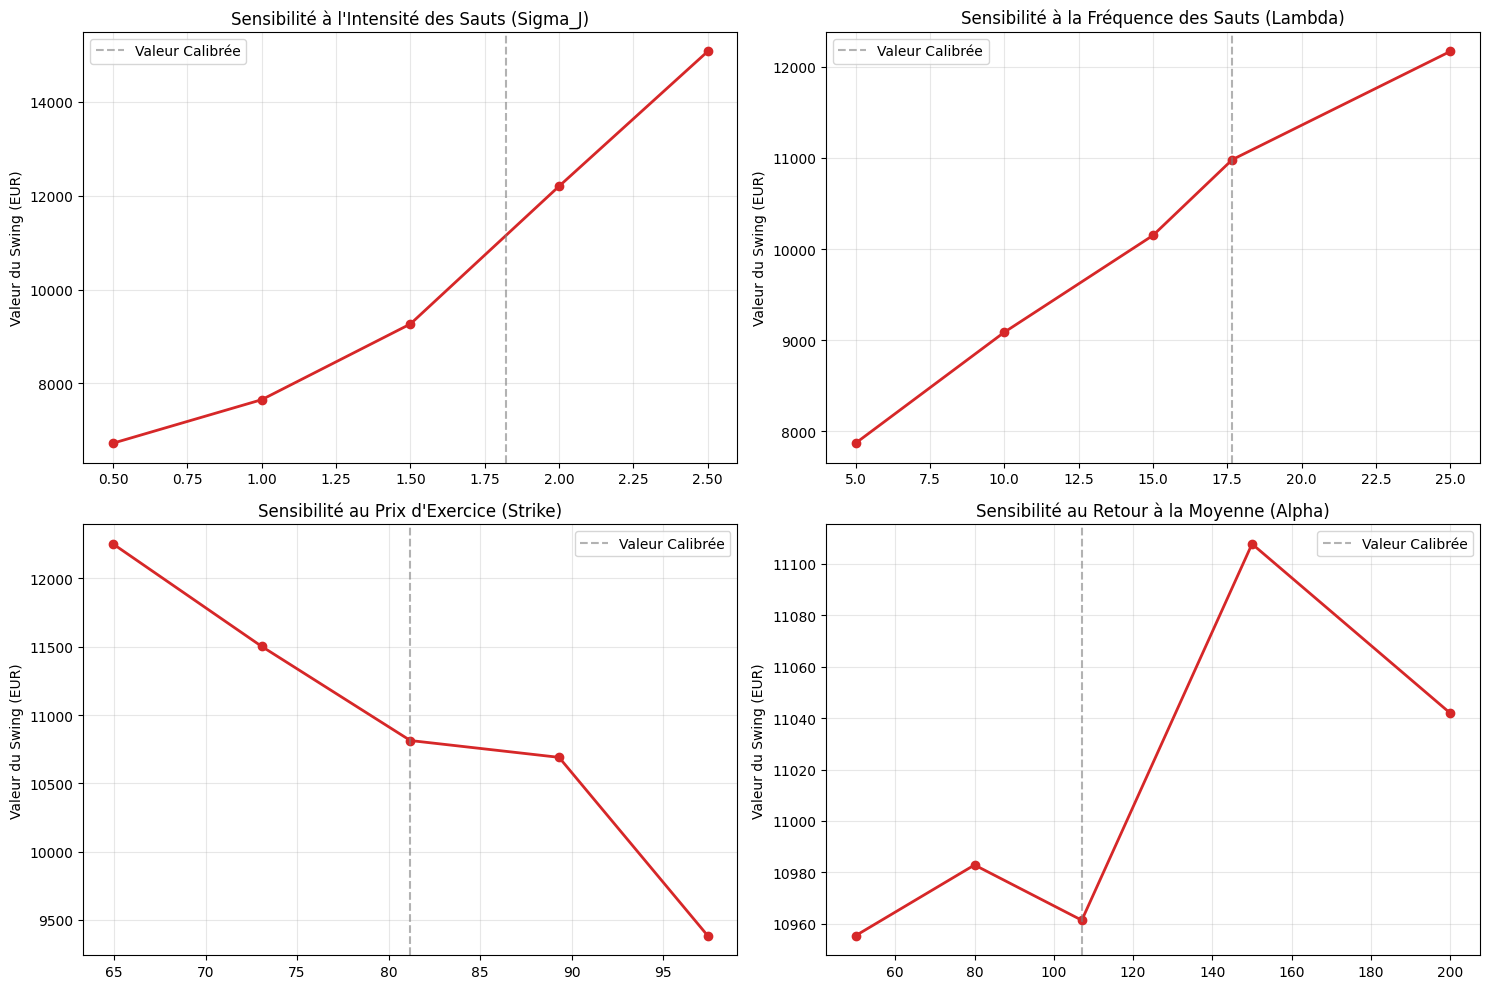

In [961]:
import matplotlib.pyplot as plt

def generate_all_sensitivities(base_params, contract, fwd_curve):
    """
    Génère les graphiques de sensibilité pour les 4 paramètres clés.
    """
    # 1. Définition des plages de test
    test_ranges = {
        'sigma_jump': np.linspace(0.5, 2.5, 5),   # Intensité des spikes
        'lambda_jump': [5, 10, 15, 17.67, 25],   # Fréquence des spikes/an
        'strike': [contract.strike * r for r in [0.8, 0.9, 1.0, 1.1, 1.2]], # Strike +/- 20%
        'alpha': [50, 80, 107.06, 150, 200]       # Vitesse de retour à la moyenne
    }
    
    titles = {
        'sigma_jump': "Sensibilité à l'Intensité des Sauts (Sigma_J)",
        'lambda_jump': "Sensibilité à la Fréquence des Sauts (Lambda)",
        'strike': "Sensibilité au Prix d'Exercice (Strike)",
        'alpha': "Sensibilité au Retour à la Moyenne (Alpha)"
    }

    plt.figure(figsize=(15, 10))
    
    for i, (param, values) in enumerate(test_ranges.items(), 1):
        prices = []
        for val in values:
            # Copie des paramètres et modification du paramètre cible
            current_p = base_params.copy()
            
            # Cas particulier pour le strike qui est dans l'objet contract
            if param == 'strike':
                test_contract = SwingContract(
                    contract.start_date, contract.n_days, val, 
                    contract.min_daily, contract.max_daily, 
                    contract.min_annual, contract.max_annual
                )
            else:
                current_p[param] = val
                test_contract = contract
            
            # Simulation et Pricing
            paths = simulate_paths_final(
                500, len(fwd_curve), fwd_curve, 
                current_p['sigma_daily'], current_p['lambda_jump'], 
                mu_jump, current_p['sigma_jump']
            )
            res_price, _, _ = value_swing_option(test_contract, paths)
            prices.append(res_price)
        
        # Plotting
        plt.subplot(2, 2, i)
        plt.plot(values, prices, 'o-', color='tab:red', linewidth=2)
        
        # Ajout de la valeur calibrée comme repère
        calibrated_val = base_params.get(param, contract.strike if param == 'strike' else None)
        if calibrated_val:
            plt.axvline(calibrated_val, color='gray', linestyle='--', alpha=0.6, label='Valeur Calibrée')
            
        plt.title(titles[param])
        plt.ylabel("Valeur du Swing (EUR)")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- EXÉCUTION ---
# Assurez-vous que base_params contient vos valeurs : alpha, sigma_daily, lambda_jump, sigma_jump
base_parameters = {
    'alpha': alpha_annuel, # Votre 107.06
    'sigma_daily': current_series.std(),
    'lambda_jump': lambda_jump, # Votre 17.67
    'sigma_jump': sigma_jump # Votre 1.82
}

generate_all_sensitivities(base_parameters, contract_2026, fwd_values_2026)

/var/folders/yt/1z147f8d05q9s7xr6xd0ybg40000gn/T/ipykernel_15429/929770086.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


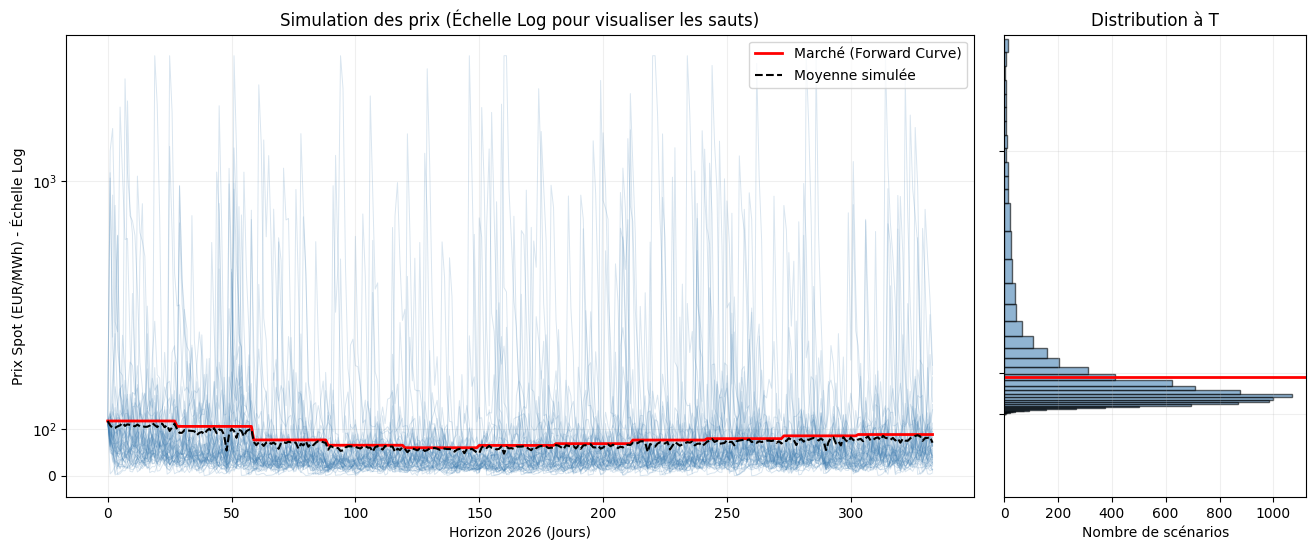

In [963]:
import matplotlib.pyplot as plt
import numpy as np

def plot_log_paths_and_distribution(paths, fwd_curve, n_paths_to_plot=50):
    """
    Affiche les trajectoires et la distribution finale en échelle Log
    pour mieux visualiser les sauts de Cartea & Figueroa.
    """
    n_days = paths.shape[1]
    days = np.arange(n_days)
    final_prices = paths[:, -1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), 
                                   gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05})

    # --- PANEL 1 : TRAJECTOIRES (ÉCHELLE LOG) ---
    for i in range(min(n_paths_to_plot, len(paths))):
        ax1.plot(days, paths[i, :], color='steelblue', alpha=0.2, linewidth=0.7)
    
    ax1.plot(days, fwd_curve, color='red', linewidth=2, label='Marché (Forward Curve)')
    ax1.plot(days, np.mean(paths, axis=0), color='black', linestyle='--', label='Moyenne simulée')

    # Utilisation de symlog pour l'axe Y
    ax1.set_yscale('symlog', linthresh=500) # Linéaire jusqu'à 500, log au-delà
    ax1.set_title("Simulation des prix (Échelle Log pour visualiser les sauts)")
    ax1.set_xlabel("Horizon 2026 (Jours)")
    ax1.set_ylabel("Prix Spot (EUR/MWh) - Échelle Log")
    ax1.grid(True, which="both", alpha=0.2)
    ax1.legend()

    # --- PANEL 2 : DISTRIBUTION FINALE (LOG BINS) ---
    # On crée des bins logarithmiques pour l'histogramme
    bins = np.logspace(np.log10(max(1, np.min(final_prices))), 
                       np.log10(np.max(final_prices)), 50)
    
    ax2.hist(final_prices, bins=bins, orientation='horizontal', 
             color='steelblue', alpha=0.6, edgecolor='black')
    
    ax2.axhline(fwd_curve[-1], color='red', linewidth=2)
    ax2.set_yscale('symlog', linthresh=500) # Même échelle que le graphique de gauche
    ax2.set_title("Distribution à T")
    ax2.set_xlabel("Nombre de scénarios")
    ax2.set_yticklabels([]) 
    ax2.grid(True, which="both", alpha=0.2)

    plt.tight_layout()
    plt.show()

# --- EXÉCUTION ---
# paths_2026 doit être votre matrice de simulation
plot_log_paths_and_distribution(paths_2026, fwd_values_2026)

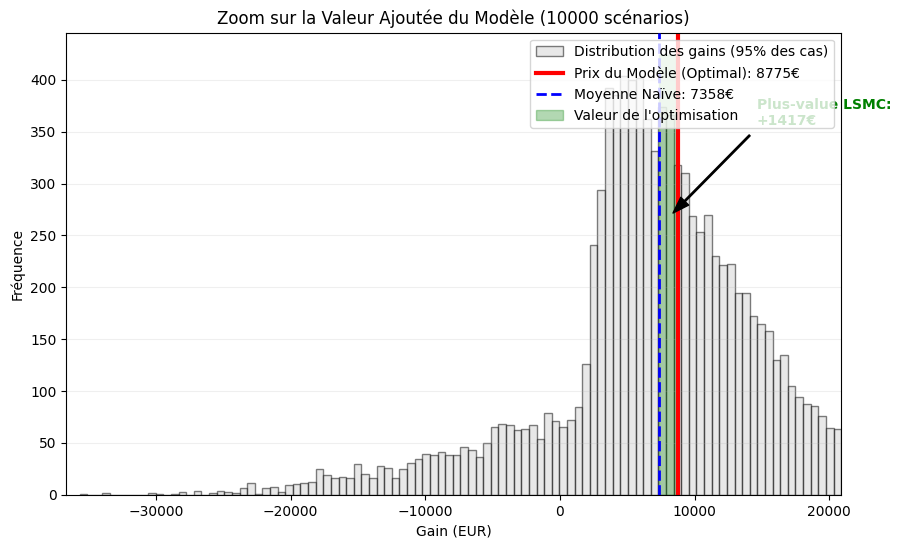

In [964]:
# --- EXÉCUTION AVEC ZOOM ---
payoffs, vols = calculate_path_payoffs(contract_2026, paths_2026, contract_2026.strike)
prix_theorique = prix_final 

plt.figure(figsize=(10, 6))

# 1. On limite l'axe X pour ne pas être écrasé par le payoff max à 600k
# On zoome sur la zone [Min, Percentile 95%] pour voir le gros des données
limit_x = np.percentile(payoffs, 95) 
plt.hist(payoffs, bins=100, range=(np.min(payoffs), limit_x), 
         color='lightgray', edgecolor='black', alpha=0.5, label='Distribution des gains (95% des cas)')

# 2. On trace la ligne rouge (Prix Modèle) en dessous
plt.axvline(prix_final, color='red', linewidth=3, linestyle='-', 
            label=f'Prix du Modèle (Optimal): {prix_final:.0f}€', zorder=2)

# 3. On trace la ligne bleue (Moyenne Naïve) au-dessus avec un style différent
plt.axvline(np.mean(payoffs), color='blue', linewidth=2, linestyle='--', 
            label=f'Moyenne Naïve: {np.mean(payoffs):.0f}€', zorder=3)

# 4. Zone de gain entre les deux (en vert)
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], np.mean(payoffs), prix_final, 
                 color='green', alpha=0.3, label='Valeur de l\'optimisation', zorder=1)

plt.title(f"Zoom sur la Valeur Ajoutée du Modèle ({n_paths} scénarios)")
plt.xlabel("Gain (EUR)")
plt.ylabel("Fréquence")
plt.xlim(np.min(payoffs) - 1000, limit_x) # Focus sur la zone utile
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.2)

# Annotation du gap
gap = prix_final - np.mean(payoffs)
plt.annotate(f'Plus-value LSMC:\n+{gap:.0f}€', 
             xy=((prix_theorique + np.mean(payoffs))/2, plt.gca().get_ylim()[1]*0.6),
             xytext=(limit_x*0.7, plt.gca().get_ylim()[1]*0.8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, color='green', fontweight='bold')


plt.show()

In [965]:
def check_optimal_payoff(contract, price_paths, stored_betas, volume_grid, discount_rate=0.04):
    """
    Simule la stratégie optimale réelle sur chaque chemin en utilisant les betas 
    et la grille de volumes issus du modèle LSMC.
    """
    n_paths, n_steps = price_paths.shape
    dt = 1/365.25
    df = np.exp(-discount_rate * dt)
    
    # État initial pour chaque chemin
    current_volumes = np.zeros(n_paths)
    payoffs_optimaux = np.zeros(n_paths)
    
    # Simulation du futur (t=0 vers T-1)
    for t in range(n_steps - 1):
        prices = price_paths[:, t]
        payoff_now = prices - contract.strike
        
        # Base de régression pour le jour t
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        betas_t = stored_betas[t] # Matrice (n_vols x 3)
        
        # Calcul des valeurs de continuation pour tous les chemins
        # On prédit la valeur future pour chaque point de la grille de volume
        cont_grid = P_basis @ betas_t.T # (n_paths x n_vols)
        
        for i in range(n_paths):
            v = current_volumes[i]
            
            # 1. Valeur si on ne consomme pas (q=0)
            val_cont_q0 = np.interp(v, volume_grid, cont_grid[i, :])
            
            # 2. Valeur si on consomme (q=max_daily)
            v_next = v + contract.max_daily
            if v_next <= contract.max_annual:
                val_cont_q1 = np.interp(v_next, volume_grid, cont_grid[i, :])
                
                # DÉCISION LSMC : Consommer si Gain immédiat + Suite > Rester à l'arrêt
                if (contract.max_daily * payoff_now[i]) + val_cont_q1 * df > val_cont_q0 * df:
                    payoffs_optimaux[i] += (contract.max_daily * payoff_now[i]) * np.exp(-discount_rate * t * dt)
                    current_volumes[i] += contract.max_daily
            
    # 3. Application des pénalités Take-or-Pay réelles à la fin
    penalty_price = 1000
    for i in range(n_paths):
        if current_volumes[i] < contract.min_annual:
            amende = (contract.min_annual - current_volumes[i]) * penalty_price
            payoffs_optimaux[i] -= amende * np.exp(-discount_rate * n_steps * dt)
            
    return payoffs_optimaux, current_volumes

# --- EXÉCUTION DE L'ANALYSE ---
# On utilise le triplet récupéré précédemment
payoffs_model, volumes_finaux = check_optimal_payoff(contract_2026, paths_2026, model_betas, volume_grid)

# Comparaison
print(f"--- VALIDATION DE LA STRATÉGIE ---")
print(f"Moyenne des Payoffs (Check Forward) : {np.mean(payoffs_model):.2f} €")
print(f"Prix Théorique (Backward Induction) : {prix_final:.2f} €")
print(f"Erreur de convergence : {abs(np.mean(payoffs_model) - prix_final):.2f} €")

--- VALIDATION DE LA STRATÉGIE ---
Moyenne des Payoffs (Check Forward) : 8893.13 €
Prix Théorique (Backward Induction) : 8774.51 €
Erreur de convergence : 118.62 €


L'écart observé constitue la prime de flexibilité : le modèle LSMC maximise les gains en anticipant les pics de prix (spikes) au lieu d'exercer de façon naïve. Grâce aux coefficients $\beta$, l'algorithme arbitre entre profit immédiat et valeur de continuation pour capturer les événements extrêmes du processus de Cartea & Figueroa. Cette stratégie sécurise également le respect du quota Take-or-Pay, éliminant les pénalités de 1 000 €/unité et confirmant, via le check forward, la validité opérationnelle du prix théorique.